[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana5/2_Redes_LSTM_y_GARCH.ipynb)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers

import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

# LSTM = Long-Short Term Memory

# Redes Neuronales

Recordemos como se ve una red neuronal densa (el tipo mas sencillo), pues la LSTM utiliza densas por dentro

![crop_NN[1].jpg](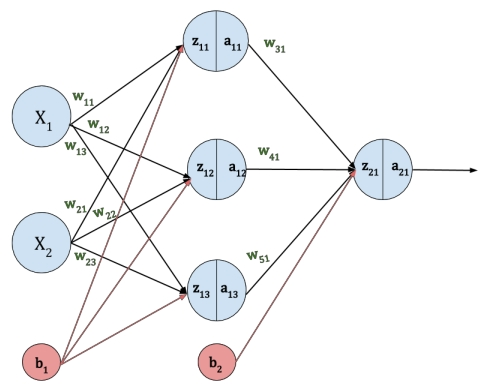)

# Como funciona UNA capa LSTM

Así se ven los parámetros mas desglosados:

![ljXeA[1].png](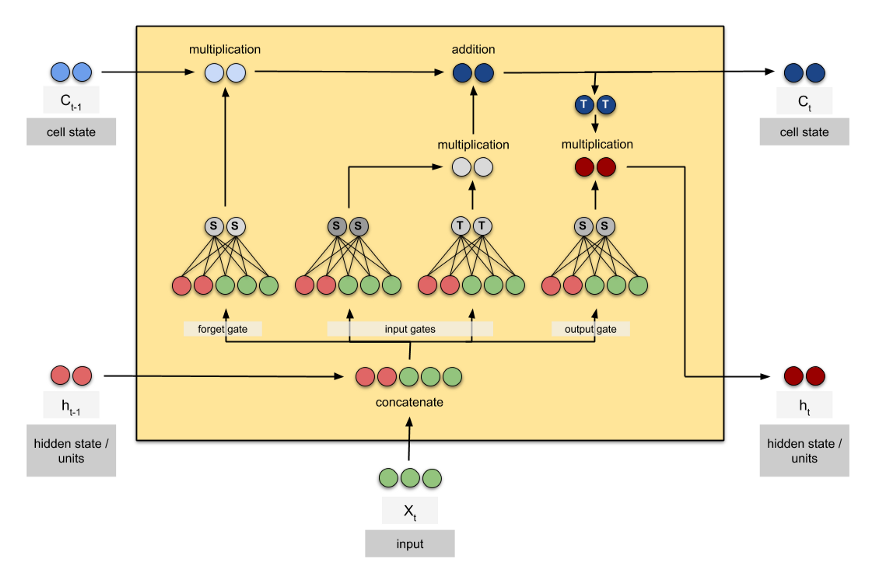)

![1_Mb_L_slY9rjMr8-IADHvwg[1].png](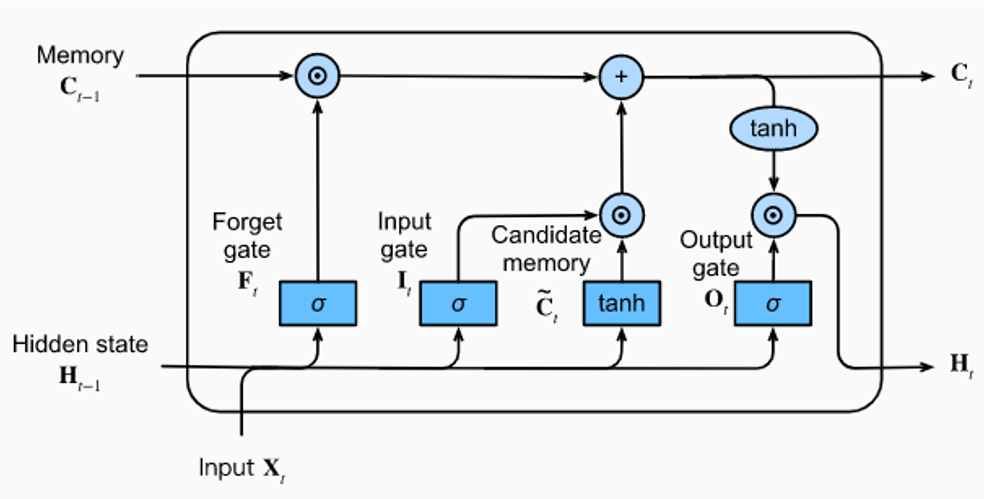)

![0_T_-9HypnVL09rnuo[1].jpeg](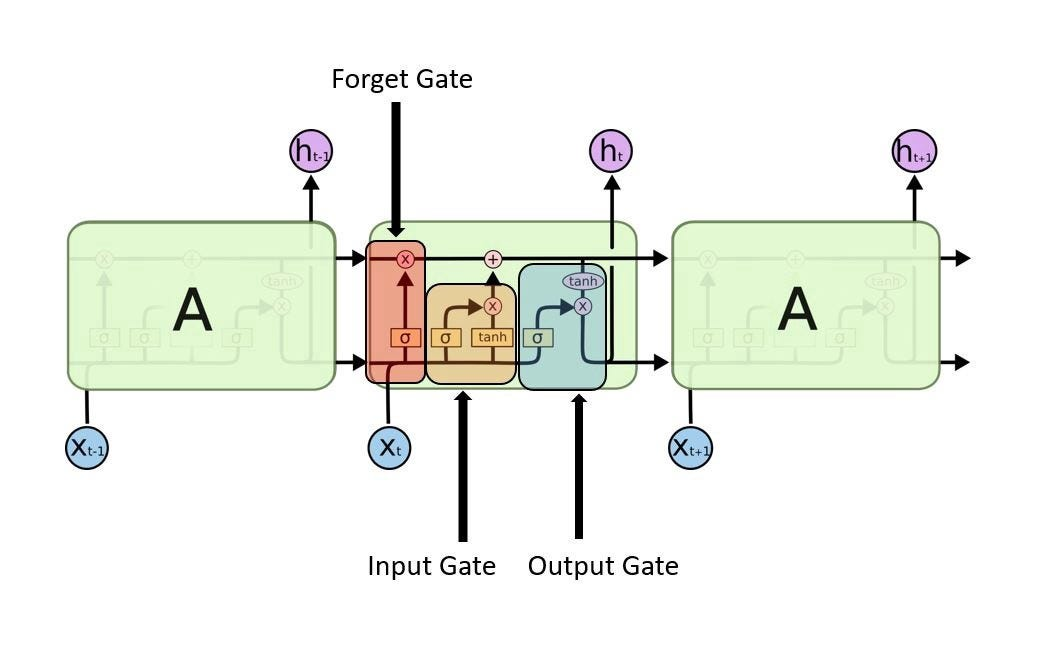)

# Datos sintéticos para comparación imparcial

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess

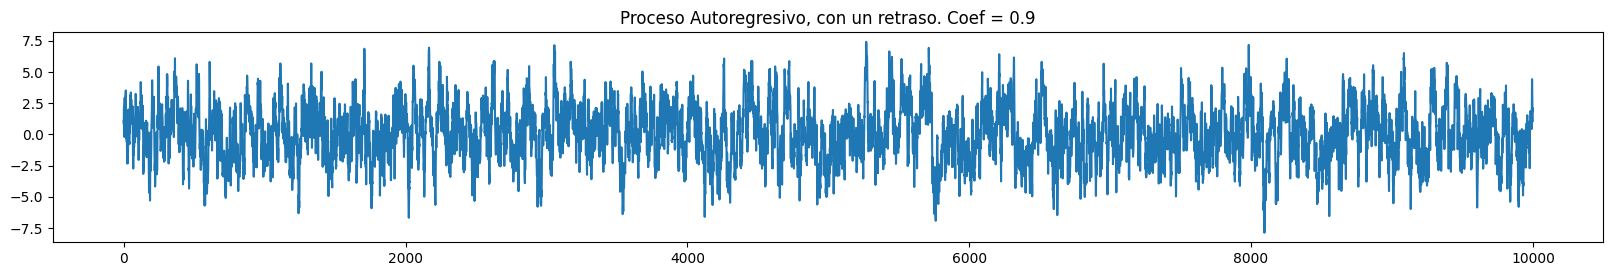

In [ ]:
coef = 0.9
plt.subplot(2,1,1)
ar = np.array([1, -0.9])
ma = np.array([1])

titulo = 'Proceso Autoregresivo, con un retraso. Coef = ' + str(coef)
AR_model = ArmaProcess(ar, ma)
plt.rc("figure", figsize=(20,4))


AR_simulacion = pd.Series(AR_model.generate_sample(nsample=10000))
AR_simulacion.plot(figsize = (20,6), title=titulo)
plt.show()

In [ ]:
AR_simulacion

0       1.091791
1       0.813008
2       2.169390
3       0.228575
4      -0.201634
          ...   
9995    3.157897
9996    2.735810
9997    1.826501
9998    2.110813
9999    1.067212
Length: 10000, dtype: float64

# Preparación datos para primer red neuronal

In [ ]:
datos_cortados = np.empty((1,2,1))
y = np.empty((1,))
for element in AR_simulacion.index[:-3]:
  muestra = np.array([[[AR_simulacion[element]], [AR_simulacion[element + 1]]]])
  datos_cortados = np.append(datos_cortados, muestra, axis=0)

  y = np.append(y, AR_simulacion[element + 2])

  # SALIDA TIENE QUE SER (x, 2, 1)

In [ ]:
AR_simulacion

0       1.091791
1       0.813008
2       2.169390
3       0.228575
4      -0.201634
          ...   
9995    3.157897
9996    2.735810
9997    1.826501
9998    2.110813
9999    1.067212
Length: 10000, dtype: float64

In [ ]:
datos_cortados[9996]

array([[3.15789714],
       [2.73581027]])

In [ ]:
y[9996]

1.8265011792896741

In [ ]:
datos_cortados.shape

(9998, 2, 1)

In [ ]:
# (5,10,1)

# Primer dimension: Tengo 5 muestras
# Segunda dimension: Cada muestra, tiene longitud 10
# Tercera dimension: Distintas series de tiempo: acciones de Netflix, acciones de Google

In [ ]:
datos_cortados[1:, :].shape

(9997, 2, 1)

In [ ]:
y[1:].shape

(9997,)

PREGUNTA: ¿Que representan las dimensiones de los datos?

In [ ]:
train = datos_cortados[1:, :].copy()
target = y[1:].copy()

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(train, target, shuffle=False, random_state=10, train_size=.90)

### Primera Aquitectura

#### Aquitectura

In [ ]:
# Definicion de las capas
price_input = layers.Input(shape = (2, 1), name = 'price_input')
price_lstm = layers.LSTM(1, name = 'price', recurrent_activation='linear')

# Como se conectan las capas definidas arriba
price_output = price_lstm(price_input)

#### Modelo

In [ ]:
# Instanciación del objeto modelo
model = keras.Model(price_input, price_output)

model.compile(
    loss = 'mean_squared_error'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 price_input (InputLayer)    [(None, 2, 1)]            0         
                                                                 
 price (LSTM)                (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Visualización

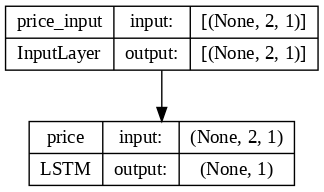

In [ ]:
# Visualización del modelo
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=100,
)

#### Entrenamiento

In [ ]:
tf.random.set_seed(20)
np.random.seed(10)

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 100,  # Valor real de 1000
).history

Epoch 1/100
71/71 [==============================] - 2s 6ms/step - loss: 1.7721
Epoch 2/100
71/71 [==============================] - 0s 7ms/step - loss: 1.2351
Epoch 3/100
71/71 [==============================] - 0s 5ms/step - loss: 1.0968
Epoch 4/100
71/71 [==============================] - 0s 6ms/step - loss: 1.0569
Epoch 5/100
71/71 [==============================] - 0s 6ms/step - loss: 1.0461
Epoch 6/100
71/71 [==============================] - 1s 8ms/step - loss: 1.0362
Epoch 7/100
71/71 [==============================] - 0s 4ms/step - loss: 1.0313
Epoch 8/100
71/71 [==============================] - 0s 3ms/step - loss: 1.0267
Epoch 9/100
71/71 [==============================] - 0s 3ms/step - loss: 1.0232
Epoch 10/100
71/71 [==============================] - 0s 3ms/step - loss: 1.0205
Epoch 11/100
71/71 [==============================] - 0s 3ms/step - loss: 1.0175
Epoch 12/100
71/71 [==============================] - 0s 3ms/step - loss: 1.0156
Epoch 13/100
71/71 [=================

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss']))

fig.show()

#### Desempeño

In [ ]:
ver = y_train.copy()

In [ ]:
train[0]

array([[1.09179101],
       [0.81300773]])

In [ ]:
y_pred_prob = model.predict(x_train)

282/282 [==============================] - 1s 2ms/step


In [ ]:
y_pred_prob

array([[0.7338457 ],
       [1.9509327 ],
       [0.20773852],
       ...,
       [0.5141281 ],
       [1.0607386 ],
       [0.38508388]], dtype=float32)

In [ ]:
ver2 = y_pred_prob.flatten()

In [ ]:
ver2.shape

(8997,)

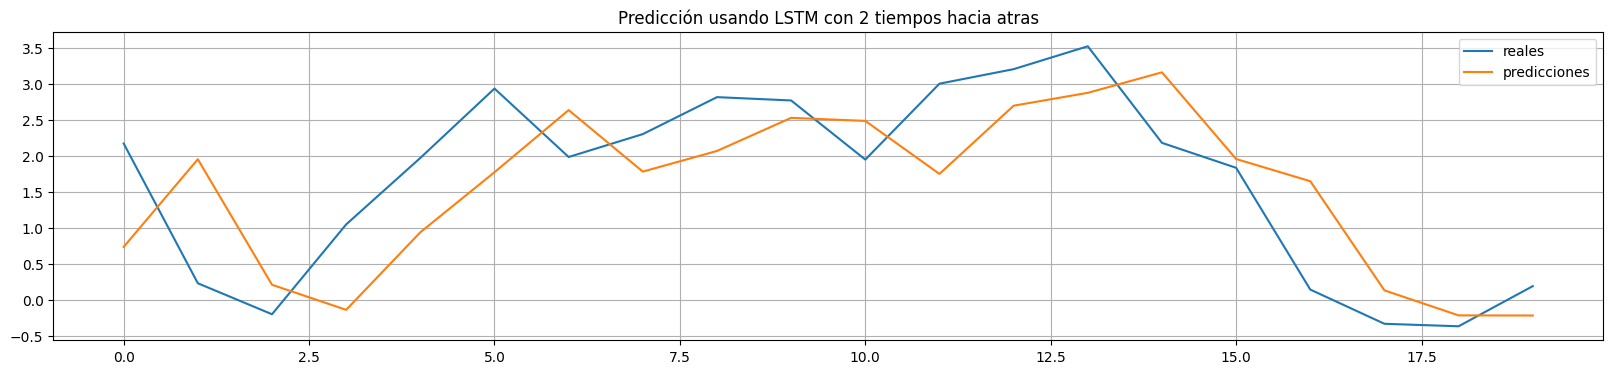

In [ ]:
plt.title('Predicción usando LSTM con 2 tiempos hacia atras')
plt.plot(ver[:20], label='reales')
plt.plot(ver2[:20], label='predicciones')
plt.legend()
plt.grid()

¿Cómo se puede interpretar a los pesos?

In [ ]:
model.get_weights()

[array([[2.2557847 , 0.28960225, 3.1817667 , 0.896927  ]], dtype=float32),
 array([[ 0.6541633 , -0.58800757, -0.2713577 , -0.00193515]],
       dtype=float32),
 array([0.29952395, 1.7834163 , 0.40161112, 0.00653149], dtype=float32)]

Es bastante complejo tratar de sacar conclusiones solo analizando los pesos

# Segunda Red Neuronal de tipo LSTM

In [ ]:
datos_cortados = np.empty((1,4,1))
y = np.empty((1,))
for element in AR_simulacion.index[:-5]:
  muestra = np.array([[[AR_simulacion[element]], [AR_simulacion[element + 1]], [AR_simulacion[element + 2]], [AR_simulacion[element + 3]]]])
  datos_cortados = np.append(datos_cortados, muestra, axis=0)

  y = np.append(y, AR_simulacion[element + 4])

  # SALIDA TIENE QUE SER (x, 4, 1)

In [ ]:
datos_cortados.shape

(9996, 4, 1)

In [ ]:
y[1:].shape

(9995,)

In [ ]:
datos_cortados[1:, :].shape

(9995, 4, 1)

In [ ]:
AR_simulacion

0       1.091791
1       0.813008
2       2.169390
3       0.228575
4      -0.201634
          ...   
9995    3.157897
9996    2.735810
9997    1.826501
9998    2.110813
9999    1.067212
Length: 10000, dtype: float64

In [ ]:
datos_cortados[1]

array([[1.09179101],
       [0.81300773],
       [2.16939041],
       [0.22857481]])

In [ ]:
y[1]

-0.20163416469058576

In [ ]:
train = datos_cortados[1:, :].copy()
target = y[1:].copy()

#### Aquitectura

In [ ]:
# Definicion de las capas
#price_input = layers.Input(shape = (4, 1), name = 'price_input')
#price_lstm = layers.LSTM( 5   , name = 'price', recurrent_activation='linear')


#capa1 = layers.Dense(32, activation = 'relu')
#capa2 = layers.Dense(1)


# Como se conectan las capas definidas arriba
#salida1 = price_lstm(price_input)
#salida2 = capa1(salida1)
#price_output = capa2(salida2)


In [ ]:
# Definicion de las capas
price_input = layers.Input(shape = (4, 1), name = 'price_input')
price_lstm = layers.LSTM( 1   , name = 'price', recurrent_activation='linear')




# Como se conectan las capas definidas arriba
price_output = price_lstm(price_input)

#### Modelo

In [ ]:
# Instanciación del objeto modelo
model = keras.Model(price_input, price_output)

model.compile(
    loss = 'mean_squared_error'
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 price_input (InputLayer)    [(None, 4, 1)]            0         
                                                                 
 price (LSTM)                (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Visualización

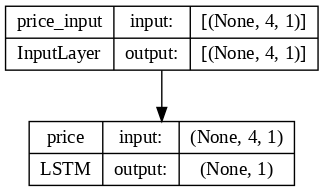

In [ ]:
# Visualización del modelo
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=100,
)

#### Entrenamiento

In [ ]:
history = model.fit(
    train, target,
    batch_size = 128,
    epochs = 100,  # Valor real de 1000
).history

Epoch 1/100
79/79 [==============================] - 2s 5ms/step - loss: 2.9727
Epoch 2/100
79/79 [==============================] - 0s 6ms/step - loss: 2.4598
Epoch 3/100
79/79 [==============================] - 0s 5ms/step - loss: 2.0763
Epoch 4/100
79/79 [==============================] - 0s 5ms/step - loss: 1.7724
Epoch 5/100
79/79 [==============================] - 0s 5ms/step - loss: 1.5194
Epoch 6/100
79/79 [==============================] - 0s 5ms/step - loss: 1.3097
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 1.1576
Epoch 8/100
79/79 [==============================] - 0s 3ms/step - loss: 1.0833
Epoch 9/100
79/79 [==============================] - 0s 3ms/step - loss: 1.0530
Epoch 10/100
79/79 [==============================] - 0s 3ms/step - loss: 1.0409
Epoch 11/100
79/79 [==============================] - 0s 3ms/step - loss: 1.0308
Epoch 12/100
79/79 [==============================] - 0s 3ms/step - loss: 1.0242
Epoch 13/100
79/79 [=================

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) #\
   #.add_trace(go.Scatter(x = x, y = history['val_loss']))

fig.show()

#### Desempeño

In [ ]:
ver = target.copy()

In [ ]:
train[0]

array([[1.09179101],
       [0.81300773],
       [2.16939041],
       [0.22857481]])

In [ ]:
y_pred_prob = model.predict(train)

313/313 [==============================] - 1s 2ms/step


In [ ]:
y_pred_prob

array([[ 0.20625076],
       [-0.17448325],
       [ 0.9461825 ],
       ...,
       [ 2.8290524 ],
       [ 2.4537377 ],
       [ 1.6388084 ]], dtype=float32)

In [ ]:
ver2 = y_pred_prob.flatten()

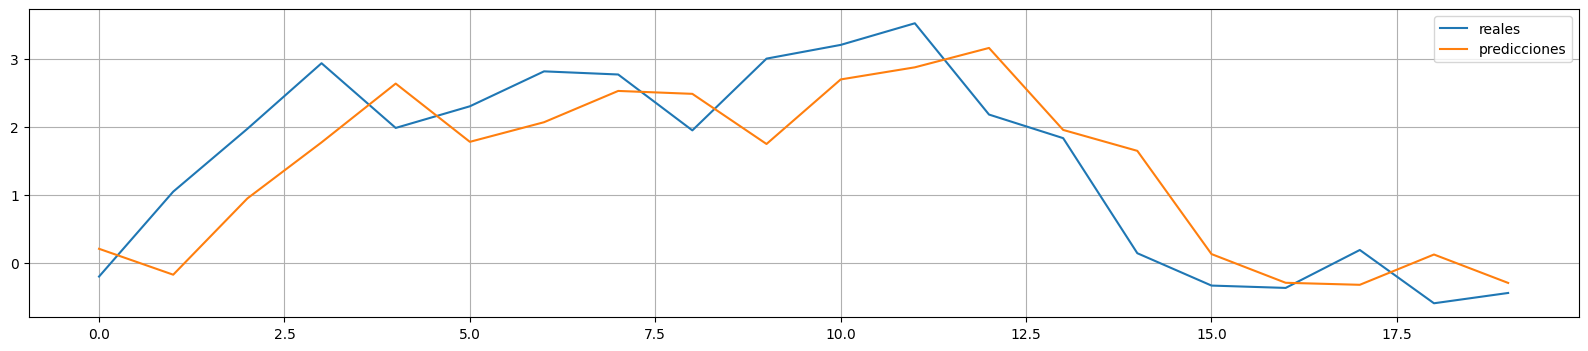

In [ ]:
plt.plot(ver[:20], label='reales')
plt.plot(ver2[:20], label='predicciones')
plt.grid()
plt.legend()

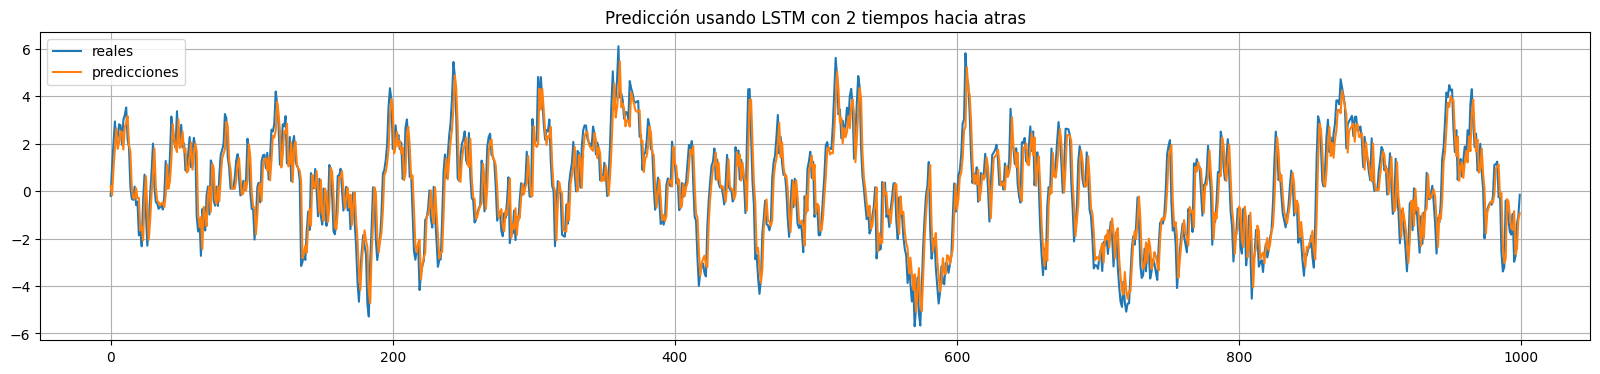

In [ ]:
plt.title('Predicción usando LSTM con 2 tiempos hacia atras')
plt.plot(ver[:1000], label='reales')
plt.plot(ver2[:1000], label='predicciones')
plt.legend()
plt.grid()

In [ ]:
model.get_weights()

# Predicción con un ARCH

In [ ]:
from random import gauss

In [ ]:
# create a simple white noise with increasing variance
from random import gauss
from random import seed
from matplotlib import pyplot
# seed pseudorandom number generator
seed(1)
# create dataset
data = [gauss(0, i*0.01) for i in range(0,100)]


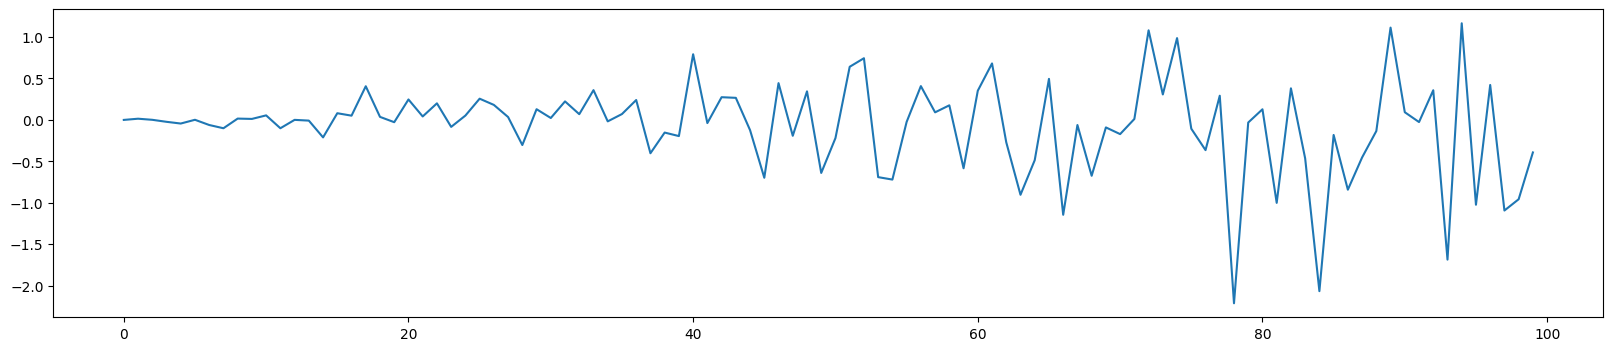

In [ ]:
# plot
pyplot.plot(data)
pyplot.show()

In [ ]:
import numpy as np

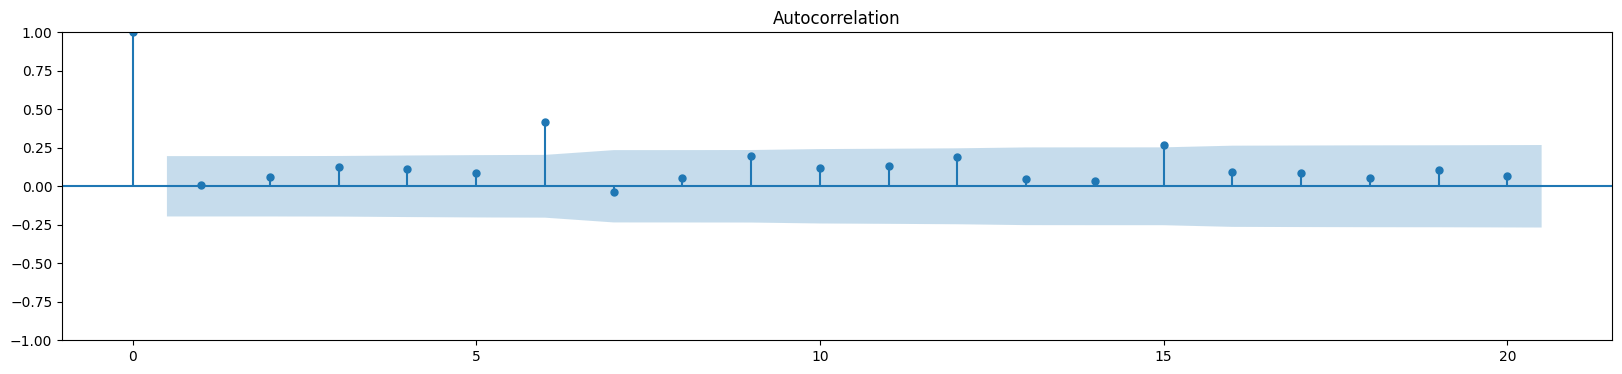

In [ ]:
# check correlations of squared observations
from statsmodels.graphics.tsaplots import plot_acf

# square the dataset
squared_data = [x**2 for x in data]
# create acf plot
plot_acf(np.array(squared_data))
pyplot.show()

In [ ]:
# split into train/test
n_test = 10
train, test = data[:-n_test], data[-n_test:]

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
# define model
model = arch_model(train, mean='Zero', vol='ARCH', p=15)

In [ ]:
# fit model
model_fit = model.fit()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 88214.15274343832
Iteration:      2,   Func. Count:     36,   Neg. LLF: 145.16327370105464
Iteration:      3,   Func. Count:     54,   Neg. LLF: 128.0887135967567
Iteration:      4,   Func. Count:     72,   Neg. LLF: 109.21731760967693
Iteration:      5,   Func. Count:     90,   Neg. LLF: 36.505726167454
Iteration:      6,   Func. Count:    108,   Neg. LLF: 39.65736210558854
Iteration:      7,   Func. Count:    126,   Neg. LLF: 28.719728253674663
Iteration:      8,   Func. Count:    143,   Neg. LLF: 28.02026266328528
Iteration:      9,   Func. Count:    161,   Neg. LLF: 34.947196664051255
Iteration:     10,   Func. Count:    180,   Neg. LLF: 30.036303168280703
Iteration:     11,   Func. Count:    198,   Neg. LLF: 26.9167818648405
Iteration:     12,   Func. Count:    216,   Neg. LLF: 35.23299678777928
Iteration:     13,   Func. Count:    235,   Neg. LLF: 25.557794471124332
Iteration:     14,   Func. Count:    253,   Neg. LLF: 25.4968

In [ ]:
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)

In [ ]:
yhat.variance.values

array([[2.09288593, 0.09017704, 1.30488414, 1.0612594 , 0.25690557,
        0.85993409, 1.82286954, 0.39067782, 1.13007601, 0.9127748 ]])

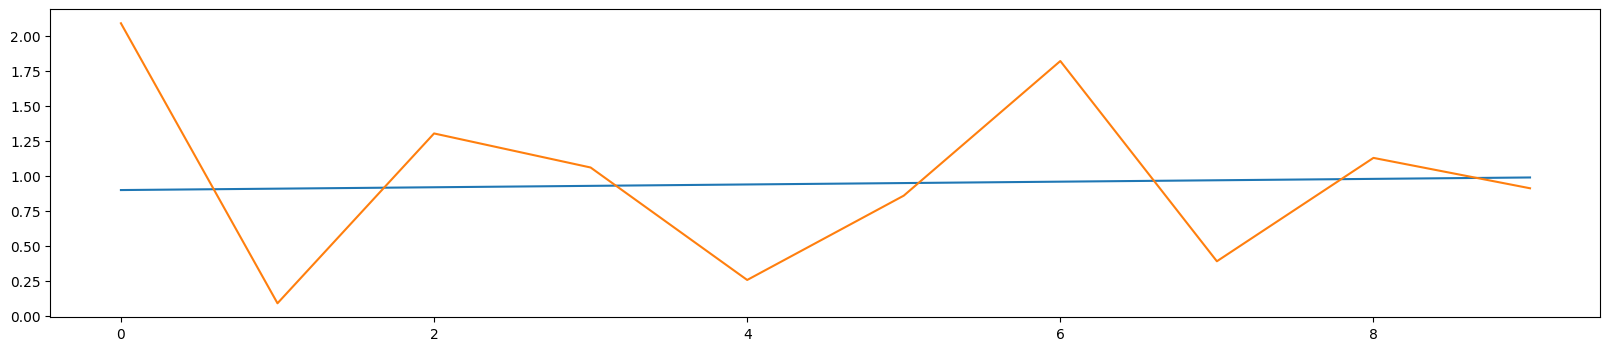

In [ ]:
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
pyplot.plot(var[-n_test:])
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

# Conclusiones

¿Porque parece arrojar tan buen resultado?

Hay que tener cuidado al sacar conclusiones

EJERCICIO: Utilice una red con capa LSTM para hacer predicción de los datos que se utilizaron en el modelo ARCH

In [ ]:
# ESPACIO PARA EJERCICIO
data




EJERCICIO: Conectar 2 capas LSTM una despues de la otra

In [ ]:
# EJERCICIO